#  Network Intrusions clustering

## importing libraries 

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN,KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA

## reading the data

In [32]:
df = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')
df=df.sample(frac=1)
df.head(10)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
117066,0.000006,udp,-,INT,2,0,168,0,166666.660800,254,...,2,1,1,1,0,0,0,1,2,0
2133,0.004145,tcp,http,FIN,8,10,1052,824,4101.326771,31,...,3,1,1,1,0,0,1,9,1,0
608,20.166878,tcp,-,FIN,28,28,4656,2976,2.727244,31,...,7,1,1,2,0,0,0,17,7,0
59642,0.549817,tcp,-,FIN,10,6,2676,268,27.281803,254,...,2,2,1,2,0,0,0,2,2,0
69351,1.589983,tcp,smtp,FIN,162,40,191555,2652,126.416447,62,...,1,1,1,1,0,0,0,1,1,0
116645,0.792287,tcp,-,FIN,10,8,564,354,21.456871,254,...,1,1,1,2,0,0,0,2,2,0
34255,0.001126,udp,dns,CON,2,2,146,178,2664.298498,31,...,1,2,1,1,0,0,0,6,2,0
149575,0.664321,tcp,smtp,FIN,18,16,1252,1116,49.674780,254,...,1,1,1,1,0,0,0,1,1,0
46282,0.522847,tcp,http,FIN,10,8,854,1104,32.514292,62,...,1,1,1,4,0,0,1,1,4,0
36890,1.052039,tcp,-,FIN,52,52,3952,19084,97.905113,31,...,4,1,1,1,0,0,0,8,10,0


## Multi Column LabelEncoder

In [33]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns
    def fit(self,X,y=None):
        return self 
    def transform(self,X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [34]:
x_train=MultiColumnLabelEncoder(columns = ['proto','service','state']).fit_transform(df)
x_test=MultiColumnLabelEncoder(columns = ['proto','service','state']).fit_transform(df_test)

take a slice from the data to use it to guess the number of clusters using dendrogram because if we took all the data we need a lot of ram

In [35]:
sli=x_train[0:2000]

## data after encoding

In [36]:
x_train.head(10)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
117066,0.000006,119,0,3,2,0,168,0,166666.660800,254,...,2,1,1,1,0,0,0,1,2,0
2133,0.004145,113,5,2,8,10,1052,824,4101.326771,31,...,3,1,1,1,0,0,1,9,1,0
608,20.166878,113,0,2,28,28,4656,2976,2.727244,31,...,7,1,1,2,0,0,0,17,7,0
59642,0.549817,113,0,2,10,6,2676,268,27.281803,254,...,2,2,1,2,0,0,0,2,2,0
69351,1.589983,113,9,2,162,40,191555,2652,126.416447,62,...,1,1,1,1,0,0,0,1,1,0
116645,0.792287,113,0,2,10,8,564,354,21.456871,254,...,1,1,1,2,0,0,0,2,2,0
34255,0.001126,119,2,0,2,2,146,178,2664.298498,31,...,1,2,1,1,0,0,0,6,2,0
149575,0.664321,113,9,2,18,16,1252,1116,49.674780,254,...,1,1,1,1,0,0,0,1,1,0
46282,0.522847,113,5,2,10,8,854,1104,32.514292,62,...,1,1,1,4,0,0,1,1,4,0
36890,1.052039,113,0,2,52,52,3952,19084,97.905113,31,...,4,1,1,1,0,0,0,8,10,0


## scale the data using standard scaler

In [37]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [38]:
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

## Using DBscan with eps=0.6 and min samples=42

In [39]:
dbscan = DBSCAN(eps=0.6, min_samples=42).fit(x_train)

In [40]:

values = np.unique(dbscan.labels_,return_counts=True)
di={k:v for k,v in zip(*values)}


In [41]:
count=0
for key in di:
    if di[key]>600:
        count+=1
count

16

## the number of clusters wiht more than 600 samples is 16

we can see that the result is not good so we will try kmeans++ with elbow method and silhouette

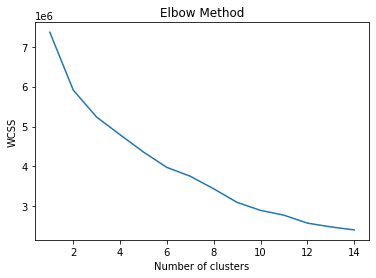

In [42]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

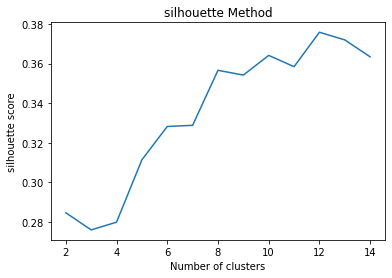

In [43]:
from sklearn.metrics import silhouette_score
silhouettes = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x_train)
    y = kmeans.predict(x_train)
    score = silhouette_score(x_train, y)
    silhouettes.append(score)
plt.plot(range(2, 15), silhouettes)
plt.title('silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.show()

## we can see that it say we need k=10, but let us try dendrogram

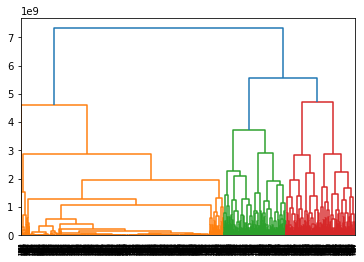

In [44]:
dendrogram = sch.dendrogram(sch.linkage(sli, method='complete'))

## we can see that 5, 6, and 10 are all accepted and let us choose 10

In [67]:
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=500, n_init=10, random_state=0)
kmeans.fit(x_train)
y_train = kmeans.predict(x_train)
y_test = kmeans.predict(x_test)


## visualizing the points

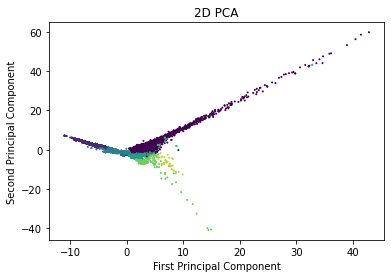

In [71]:
dim_reducer = PCA(n_components=2)
x_test_red = dim_reducer.fit_transform(x_test)
plt.scatter(x_test_red[:,0],x_test_red[:,1],c=y_test.astype(float),s=1)
plt.title("2D PCA")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()